# Calculating the $[EC_{50}]$ and Effective Hill Coefficient

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).  

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.lines as mlines

import mwc_induction_utils as mwc
mwc.set_plotting_style()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In the paper we discuss several features of induction curves that can be gleaned from our model. One of these, the effective hill coefficient, quanitfies the slope of the plot at the EC50. Here we explore how the EC50 and the effective Hill coefficient depend on the repressor copy number R and the operator binding energy $\Delta \varepsilon_{RA}$.

The effective Hill coefficient, $h$ is given by the equation

\begin{equation}
h = \left(2 \frac{d}{d\log{c}} \left[ \log{\left(\frac{\mathrm{foldchange}(c)-\mathrm{leakiness}}{\mathrm{dynamic\ range}}\right)} \right] \right)_{c = EC_{50}}.
\end{equation}

For visual simplicity, we will henceforth refer to fold-change as $\mathrm{fc}$, leakiness as $L$, and dynamic range as $D$. The above equation simplifies to 

\begin{equation}
h = \frac{2}{\mathrm{fc}(c) - L} \frac{d}{d \log{c}} \mathrm{fc}(c)
\end{equation}

We now need to differentiate $\mathrm{fc}$ with respect to the log of concentration. Let us define a variable $C = \log{c}$. When we substitute this into the $\mathrm{fc}$ equation we get

\begin{equation}
\mathrm{fc} = \left( 1 + \frac{\left( 1 + \frac{e^C}{K_A} \right)^2}{\left( 1 + \frac{e^C}{K_A} \right)^2 + e^{-\beta \Delta \varepsilon_{AI}} \left( 1 + \frac{e^C}{K_I} \right)^2} \frac{R}{N_{NS}}e^{-\beta \Delta \varepsilon_{RA}} \right)^{-1}.
\end{equation}

We differentiate with respect to $C$, giving us

\begin{equation}
\frac{\partial \mathrm{fc}}{\partial C} = -\mathrm{fc}(c)^2 \frac{R}{N_{NS}}e^{-\beta \Delta \varepsilon_{RA}} \frac{2 e^{C} e^{-\beta \Delta \varepsilon_{AI}} \left[\frac{1}{K_A} \left( 1 + \frac{e^C}{K_A} \right) \left( 1 + \frac{e^C}{K_I} \right)^2 - \frac{1}{K_I} \left( 1 + \frac{e^C}{K_A} \right)^2 \left( 1 + \frac{e^C}{K_I} \right)\right]}{\left[ \left( 1 + \frac{e^C}{K_A} \right)^2 + e^{-\beta \Delta \varepsilon_{AI}} \left( 1 + \frac{e^C}{K_I} \right)^2 \right]^2},
\end{equation}

where to save space "$\mathrm{fc}(c)$" is used to denote the portion of the equation that is equal to the original fold-change equation. Converting back to the concentration variable $c$ gives us

\begin{equation}
\frac{d}{d \log{c}} \mathrm{fc}(c) = -\mathrm{fc}^2 \frac{R}{N_{NS}}e^{-\beta \Delta \varepsilon_{RA}} \frac{2 c e^{-\beta \Delta \varepsilon_{AI}} \left[\frac{1}{K_A} \left( 1 + \frac{c}{K_A} \right) \left( 1 + \frac{c}{K_I} \right)^2 - \frac{1}{K_I} \left( 1 + \frac{c}{K_A} \right)^2 \left( 1 + \frac{c}{K_I} \right)\right]}{\left[ \left( 1 + \frac{c}{K_A} \right)^2 + e^{-\beta \Delta \varepsilon_{AI}} \left( 1 + \frac{c}{K_I} \right)^2 \right]^2},
\end{equation}

Evaluating at $c = EC_{50}$ gives us the effective Hill coefficient. The $EC_{50}$ is given by the concentration at which

\begin{equation}
\mathrm{fc}\left(EC_{50} \right) = \frac{1}{2}\left(\mathrm{fc}\left(c=0 \right) + \mathrm{fc}\left(c \rightarrow \infty \right)\right).
\end{equation}

The $EC_{50}$ evaluates to 

\begin{equation}
EC_{50} = K_A \left( \frac{ \frac{K_A}{K_I} -1}{\frac{K_A}{K_I} - \left( \frac{1 + \frac{R}{N_{NS}}e^{-\beta \Delta \varepsilon_{RA}} + \left( \frac{K_A}{K_I} \right)^n \left( 2 e^{-\beta \Delta \varepsilon_{AI}} + 1 + \frac{R}{N_{NS}}e^{-\beta \Delta \varepsilon_{RA}}\right)}{2 \left( 1 + \frac{R}{N_{NS}}e^{-\beta \Delta \varepsilon_{RA}} \right) + e^{-\beta \Delta \varepsilon_{AI}} + \left( \frac{K_A}{KI} \right)^n e^{-\beta \Delta \varepsilon_{AI}}} \right)^{\frac{1}{n}}} -1 \right).
\end{equation}

The $EC_{50}$ and $h$ are plotted for O1 with variable repressor copy number below.

In [44]:
# Functions for calculating fold change, EC50, and effective Hill coefficient

def pact(IPTG, K_A, K_I, e_AI):
    '''
    Computes the probability that a repressor is active
    Parameters
    ----------
    IPTG : array-like
        Array of IPTG concentrations in uM
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state
    Returns
    -------
    probability that repressor is active
    '''
    pact = (1 + IPTG * 1 / K_A)**2 / \
    (((1 + IPTG * 1 / K_A))**2 + np.exp(-e_AI) * (1 + IPTG * 1 / K_I)**2)
    return pact

def fold_change(IPTG, K_A, K_I, e_AI, R, Op):
    '''
    Computes fold-change for simple repression
    Parameters
    ----------
    IPTG : array-like
        Array of IPTG concentrations in uM
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state
    R : float
        Number of repressors per cell
    Op : float
        Operator binding energy
    Returns
    -------
    probability that repressor is active
    '''
    return 1 / (1 + R / 5E6 * pact(IPTG, K_A, K_I, e_AI) * np.exp(-Op))

def EC50(K_A, K_I, e_AI, R, Op):
    '''
    Computes the concentration at which half of the repressors are in the active state
    Parameters
    ----------
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state
    Returns
    -------
    Concentration at which half of repressors are active (EC50)
    '''
    t = 1 + (R / 5E6) * np.exp(-Op) + (K_A / K_I)**2 * (2 * np.exp(-e_AI) + 1 + (R / 5E6) * np.exp(-Op))
    b = 2 * (1 + (R / 5E6) * np.exp(-Op)) + np.exp(-e_AI) + (K_A / K_I)**2 * np.exp(-e_AI)
    return K_A * ((K_A / K_I - 1)/(K_A / K_I - (t/b)**(1/2)) -1)

def effective_Hill(K_A, K_I, e_AI, R, Op):
    '''
    Computes the effective Hill coefficient
    Parameters
    ----------
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state
    Returns
    -------
    effective Hill coefficient
    '''
    c = EC50(K_A, K_I, e_AI, R, Op)
    return 2/(fold_change(c, K_A, K_I, e_AI, R, Op) - fold_change(0, K_A, K_I, e_AI, R, Op))*\
           (-(fold_change(c, K_A, K_I, e_AI, R, Op))**2 * R / 5E6 * np.exp(-Op) * \
            2 * c * np.exp(-e_AI) * (1/K_A * (1 + c/K_A) * (1 + c/K_I)**2 - 1/K_I *\
           (1 + c/K_A)**2 * (1 + c/K_I)) / ((1 + c/K_A)**2 + np.exp(-e_AI) * (1 + c/K_I)**2)**2)

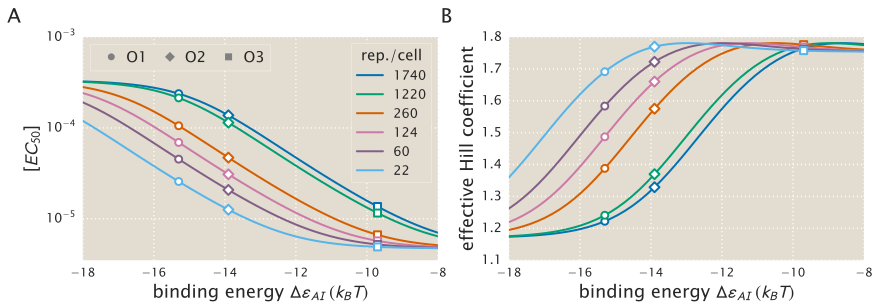

In [116]:
# Define parameters
K_A = 139
K_I = 0.53
e_AI = 4.5
ops_range = np.linspace(-18, -8, 50)
Reps = np.array([1740, 1220, 260, 124, 60, 22])
O1 = -15.3
O2 = -13.9
O3 = -9.7
ops = [O1, O2, O3]
markers = ['o', 'D', 's']
names = ['O1', 'O2', 'O3']
op_dict = dict(zip(ops, markers))

# Set color palette
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

for i in range(len(Reps)):
    ax[0].semilogy(ops_range, EC50(K_A, K_I, e_AI, Reps[i], ops_range)*1E-6, color=colors[i], label=Reps[i])
    ax[1].plot(ops_range, effective_Hill(K_A, K_I, e_AI, Reps[i], ops_range), color=colors[i])
    for op in ops:
        ax[0].semilogy(op, EC50(K_A, K_I, e_AI, Reps[i], op)*1E-6, op_dict[op],
                       markerfacecolor='white', markeredgecolor=colors[i], markeredgewidth=2)
        ax[1].plot(op, effective_Hill(K_A, K_I, e_AI, Reps[i], op), op_dict[op],
                   markerfacecolor='white', markeredgecolor=colors[i], markeredgewidth=2)

# Plot legend
ims = []
for i in range(3):
    ims.append(mlines.Line2D([], [], color='gray', marker=markers[i], label=names[i], linestyle='None'))
ax[0].add_artist(ax[0].legend(handles=ims, ncol=3, loc='upper left', handletextpad=0, columnspacing=0.5, fontsize=15))
leg = ax[0].legend(title='rep./cell')
leg.get_title().set_fontsize(15)

# Set axes properties
ax[0].set_ylim(3.5E-6, 1E-3)
ax[0].set_xlabel(r'binding energy $\Delta \varepsilon_{AI}\ (k_BT)$')
ax[1].set_xlabel(r'binding energy $\Delta \varepsilon_{AI}\ (k_BT)$')
ax[0].set_ylabel(r'[$EC_{50}$]')
ax[1].set_ylabel('effective Hill coefficient')

plt.figtext(0.05, 0.95, 'A', fontsize=20)
plt.figtext(0.48, 0.95, 'B', fontsize=20)